# kuzushiji-MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz

--2024-07-14 10:50:29--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz’

kmnist-train-imgs.n 100%[===================>]  17.53M  1.52MB/s    in 14s     

2024-07-14 10:50:44 (1.22 MB/s) - ‘kmnist-train-imgs.npz’ saved [18384171/18384171]

--2024-07-14 10:50:44--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29700 (29K)
Saving to: ‘kmnist-train-labels.npz’

kmnist-train-labels 100%[===================>]  29.00K   182KB/s    in 0.2s    

2024-07-14 10:50:45 (182 KB/s) - ‘kmnist-train-labels.npz’ saved [29700/29

In [ ]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
X_train = load('kmnist-train-imgs.npz')
X_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
X_train[0].shape, X_test[0].shape

((28, 28), (28, 28))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

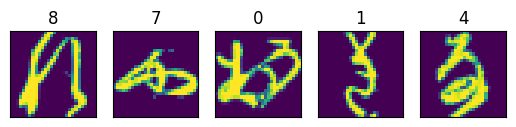

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = 28 * 28
hidden_dims = [int(mnist_dim/8)]
output_dim = 10

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net1.fit(X_train, y_train)
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0346       0.8288        0.5873  1.5596
      2        0.6281       0.8632        0.4563  1.0608
      3        0.5362       0.8812        0.3989  1.0496
      4        0.4877       0.8908        0.3614  1.0939
      5        0.4532       0.8976        0.3380  1.0360
      6        0.4285       0.9041        0.3189  1.0171
      7        0.4121       0.9070        0.3084  1.3549
      8        0.3891       0.9122        0.2945  1.4779
      9        0.3816       0.9137        0.2890  1.6491
     10        0.3709       0.9176        0.2768  1.4695
     11        0.3621       0.9197        0.2743  1.0678
     12        0.3529       0.9203        0.2685  1.0304
     13        0.3476       0.9228        0.2620  1.0525
     14        0.3374       0.9226        0.2593  1.0510
     15        0.3345       0.9239        0.2552  1.0669
     16        0.3226       0.9

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.8435

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3564       0.8000        0.6730  1.1552
      2        0.7620       0.8539        0.4901  1.2246
      3        0.6093       0.8775        0.4119  1.1648
      4        0.5186       0.8912        0.3580  1.1264
      5        0.4650       0.9022        0.3306  1.3142
      6        0.4162       0.9077        0.3072  2.5288
      7        0.3827       0.9107        0.2956  3.3097
      8        0.3571       0.9152        0.2793  1.9093
      9        0.3328       0.9154        0.2761  1.2254
     10        0.3182       0.9205        0.2664  1.1508
     11        0.2960       0.9253        0.2580  1.1630
     12        0.2821       0.9237        0.2586  1.2131
     13        0.2732       0.9277        0.2465  1.1467
     14        0.2609       0.9287        0.2475  1.1824
     15        0.2495       0.9277        0.2487  1.4957
     16        0.2370       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.8446

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2467       0.7995        0.6603  1.1383
      2        0.6918       0.8485        0.4935  1.1046
      3        0.5707       0.8690        0.4291  1.1091
      4        0.4971       0.8818        0.3800  1.1170
      5        0.4485       0.8890        0.3643  1.3484
      6        0.4113       0.9000        0.3293  1.5707
      7        0.3809       0.9052        0.3173  1.2189
      8        0.3575       0.9065        0.3150  1.1584
      9        0.3367       0.9103        0.2989  1.1253
     10        0.3241       0.9091        0.2998  1.0839
     11        0.3064       0.9123        0.2927  1.0964
     12        0.2934       0.9157        0.2868  1.1144
     13        0.2832       0.9127        0.2928  1.0889
     14        0.2669       0.9162        0.2865  1.0908
     15        0.2621       0.9178        0.2811  1.1119
     16        0.2502       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.8275

In [ ]:
error_mask = y_pred != y_test

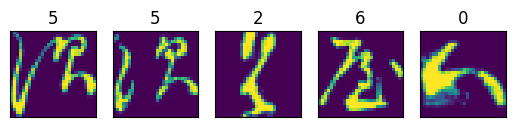

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
[mnist_dim//4, mnist_dim//2]

[196, 392]

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2852       0.8014        0.6530  1.1864
      2        0.7290       0.8454        0.4956  1.1079
      3        0.6060       0.8692        0.4179  1.0991
      4        0.5256       0.8838        0.3763  1.1027
      5        0.4676       0.8946        0.3423  1.1147
      6        0.4279       0.9010        0.3231  1.3861
      7        0.3934       0.9110        0.2964  1.4330
      8        0.3653       0.9135        0.2851  1.0950
      9        0.3473       0.9154        0.2802  1.1025
     10        0.3286       0.9192        0.2722  1.0954
     11        0.3087       0.9207        0.2673  1.0994
     12        0.2925       0.9220        0.2634  1.0905
     13        0.2830       0.9229        0.2603  1.0858
     14        0.2701       0.9253        0.2589  1.0843
     15        0.2608       0.9222        0.2656  1.4581
     16        0.2535       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.8451

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3025       0.1692        2.2979  1.2938
      2        2.1595       0.1946        1.8559  1.2744
      3        1.8141       0.4262        1.5069  1.3018
      4        1.5045       0.7123        1.0864  1.2927
      5        1.1728       0.7762        0.7697  1.6069
      6        0.9717       0.8143        0.6694  1.6718
      7        0.8890       0.8274        0.6455  1.2666
      8        0.8185       0.8433        0.5843  1.2750
      9        0.7889       0.8398        0.6078  1.2791
     10        0.7490       0.8483        0.5640  1.2751
     11        0.7202       0.8558        0.5308  1.2602
     12        0.6814       0.8616        0.5403  1.2802
     13        0.6479       0.8620        0.5497  1.2647
     14        0.6186       0.8642        0.5335  1.4814
     15        0.6024       0.8661        0.5142  1.8016
     16        0.5902       0.8

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.7583

In [ ]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = corr.cpu().detach().numpy()
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

In [ ]:
for i in range(len(nets)):
  for j in range(i + 1, len(nets)):
    correlation = get_correlation(nets[i].module, nets[j].module, torch.tensor(X_test).to(device))
    print("correlation between net" + str(i + 1) + " and net" + str(j + 1) + ":", correlation)

correlation between net1 and net2: 0.57208073
correlation between net1 and net3: 0.5557628
correlation between net1 and net4: 0.58108485
correlation between net1 and net5: 0.5101588
correlation between net2 and net3: 0.62256503
correlation between net2 and net4: 0.6189548
correlation between net2 and net5: 0.5115519
correlation between net3 and net4: 0.67899024
correlation between net3 and net5: 0.5379509
correlation between net4 and net5: 0.53018576


In [ ]:
def get_layers_names(net):
  children = []
  for child in net.named_children():
    if isinstance(child[1], nn.Dropout):
      continue
    elif isinstance(child[1], nn.ModuleList):
      for ch in child[1]._modules:
        children.append((child[1], child[0], ch))
    else:
      children.append(child[0])
  return children

get_layers_names(net2.module)

[(ModuleList(
    (0): Linear(in_features=784, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
  ),
  'hidden',
  '0'),
 (ModuleList(
    (0): Linear(in_features=784, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
  ),
  'hidden',
  '1'),
 'output']

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# def get_outputs(net, test):
#   layers = get_layers_names(net)
#   layer_num = 0
#   layer_nums = None
#   Ts = None
#   for layer in layers:
#     if isinstance(layer[0], nn.ModuleList):
#       net._modules[layer[1]]._modules[layer[2]].register_forward_hook(get_activation(layer[2]))
#       out = net(test)
#       output = activation[layer[2]]
#     else:
#       getattr(net, layer).register_forward_hook(get_activation(layer))
#       out = net(test)
#       output = activation[layer]
#     Ts = torch.cat((Ts, output), 1) if Ts is not None else output
#     l = torch.ones_like(output) * layer_num
#     layer_nums = torch.cat((layer_nums, l), 1) if layer_nums is not None else l
#     layer_num += 1
#   return Ts, layer_nums


# get_outputs(net2.module, torch.tensor(X_test).to(device))

# Convolutional Network


In [ ]:
# XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [ ]:
# XCnn_train.shape, y_train.shape

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8320       0.9183        0.2745  2.2241
      2        0.4532       0.9425        0.1956  1.7795
      3        0.3769       0.9517        0.1609  1.8010
      4        0.3438       0.9568        0.1454  1.9166
      5        0.3170       0.9590        0.1352  2.1884
      6        0.2950       0.9628        0.1224  1.8233
      7        0.2780       0.9649        0.1117  1.7884
      8        0.2630       0.9678        0.1098  1.7996
      9        0.2545       0.9681        0.1029  1.7873
     10        0.2429       0.9699        0.0989  1.7808


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9174

In [ ]:
X_test.shape

(2000, 784)

In [ ]:
for i in range(len(nets)):
  correlation = get_correlation(nets[i].module, cnn.module, torch.tensor(X_test[:10]).to(device))
  print("correlation between net" + str(i + 1) + " and cnn:", correlation)

correlation between net1 and cnn: 0.90018266
correlation between net2 and cnn: 0.7688588
correlation between net3 and cnn: 0.90984225
correlation between net4 and cnn: 0.89354587
correlation between net5 and cnn: 0.5188956
